## CT5135 Research Topics in AI

## Assignment 2

* Student ID(s): 22229358, 22230186, 20230220
* Student name(s): KOSTADIN GEORGIEV, YAMINI GIRKAR, SHUBHAM MANGLAM

### Imports

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, activations
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

### Transform Data

Provided images are of different heights so they should be resized to the same resolution.

First, create a function which applies callback to each .jpg image in a directory:

In [2]:
def walk_directory(dir, callback, label=None):
    for dirname, _, filenames in os.walk(dir):
        for filename in filenames:
            if filename.endswith(".jpg"):
                id = filename[:-4]
                pathname = os.path.join(dirname, filename)
                im = Image.open(pathname)
                imnp = np.array(im, dtype=float)

                if len(imnp.shape) != 3:
                    print("This is 1 channel, so we omit it",
                          imnp.shape, filename)
                    continue

                callback(id, imnp, label)

Observe the dimensions of each image in the dataset:

In [3]:
df = pd.DataFrame(columns=['height', 'width', 'channels', 'label'])

def get_img_shape(id, imnp, label):
    height, width, channel = imnp.shape
    df.loc[id] = [height, width, channel, label]

walk_directory('dataset/alpaca', get_img_shape, 'alpaca')
walk_directory('dataset/not_alpaca', get_img_shape, 'not_alpaca')

df

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


,height,width,channels,label
01ad3ff1d94eb557,670,1024,3,alpaca
0346463867a297f4,768,1024,3,alpaca
038fae9e70c4c3f1,768,1024,3,alpaca
053608552d63f724,768,1024,3,alpaca
053dab62fbb47736,682,1024,3,alpaca
...,...,...,...,...
eb4d2e0c0252fdc2,682,1024,3,not_alpaca
eb4f5968c7866a3e,699,1024,3,not_alpaca
f4495f8511553631,680,1024,3,not_alpaca
f8d3c3d8be68c4fd,768,1024,3,not_alpaca


In [4]:
IMG_HEIGHT = df['height'].min()
IMG_WIDTH = df['width'].min()

IMG_HEIGHT = 28
IMG_WIDTH = 28

print('Images will be resized to', IMG_HEIGHT, 'x', IMG_WIDTH)

Images will be resized to 28 x 28


In [5]:
def resize_images(label):
    source_dir = 'dataset/' + label
    target_dir = 'dataset_resized/'+ label
    subset = df.loc[df['label'] == label]

    for id, image in subset.iterrows():
        id = str(id)
        filename = id + ".jpg"
        
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        
        image = Image.open(source_path)
        image = image.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
        image.save(target_path)

In [6]:
resize_images('alpaca')
resize_images('not_alpaca')

### Load Data

In [7]:
def load_images(dir):
    img_array = []
    
    walk_directory(dir, lambda id, imnp, label: img_array.append(imnp))

    return np.array(img_array)

In [8]:
img_alpaca = load_images('dataset_resized/alpaca')
img_not_alpaca = load_images('dataset_resized/not_alpaca')

In [9]:
print('alpaca:', img_alpaca.shape)
print('not_alpaca:', img_not_alpaca.shape)

alpaca: (142, 28, 28, 3)
not_alpaca: (183, 28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


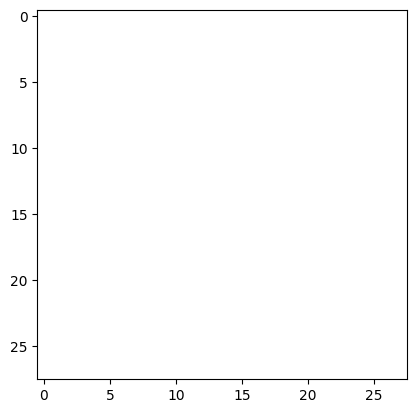

In [10]:
plt.figure(0)
plt.imshow(img_alpaca[0])
plt.show()

### Pre-Process Data

Create arrays for all images and for all labels:

In [11]:
lbl_alpaca = np.ones(img_alpaca.shape[0], dtype=int)
lbl_not_alpaca = np.zeros(img_not_alpaca.shape[0], dtype=int)
labels = np.concatenate((lbl_alpaca, lbl_not_alpaca), axis=0)
img_array = np.concatenate((img_alpaca, img_not_alpaca), axis=0)
print('img_array:', img_array.shape)
print('labels:', labels.shape)

img_array: (325, 28, 28, 3)
labels: (325,)


Scale down data from 0-255 to 0-1:

In [12]:
img_array_scaled = img_array / 255

Create one-hot encodings for the labels:

In [13]:
labels_one_hot_encode = to_categorical(labels)

### Create Train/Test Splits

Use 80% of the dataset as training data and 20% for testing.

In [23]:
(X_train, X_test,
 y_train, y_test) = train_test_split(img_array_scaled, labels_one_hot_encode,
                                     train_size = 0.8, random_state = 22229358)

### Implement Proposed Layer

#### Diagram of the proposed convolution operation

H = height of input image

W = width of input image

C = number of channels of input

![Proposed Layer](img/proposed_layer.png)

In [24]:
class ProposedLayer(layers.Layer):
    def __init__(self, filters, rf=(3, 3), activation=None, **kwargs):
        super(ProposedLayer, self).__init__(**kwargs)
        self.filters = filters
        self.rf = rf
        self.activation = activations.get(activation)
    
    def build(self, input_shape):
        batch_size, height, width, channels = input_shape
        w_shape = tf.TensorShape((height, width, channels, self.filters))
        b_shape = tf.TensorShape((self.filters,))
        
        batch_size = 1 if batch_size is None else batch_size
        z_height = height - self.rf[0] + 1
        z_width = width - self.rf[1] + 1
#         self.z_shape = (batch_size, z_height, z_width, self.filters)
#         self.z = tf.Variable(tf.zeros(self.z_shape, tf.float32), trainable=False)

        self.W = self.add_weight(name='kernel', shape=w_shape,
                                 initializer='glorot_uniform',
                                 trainable=True, dtype=tf.float32)
        self.B = self.add_weight(name='bias', shape=b_shape,
                                 initializer='zeros',
                                 trainable=True, dtype=tf.float32)
        
        super(ProposedLayer, self).build(input_shape)

    def call(self, X):
        batch_size, height, width, _ = X.shape
        batch_size = 1 if batch_size is None else batch_size
        z_height = height - self.rf[0] + 1
        z_width = width - self.rf[1] + 1
        z_shape = (batch_size, z_height, z_width, self.filters)
        output_list = []
#         z = tf.zeros(z_shape, dtype=np.float32)
#         z = tf.Variable(lambda: tf.zeros(z_shape, tf.float32), trainable=False)

        for sample in range(batch_size):
            k_list = []
            for k in range(self.filters):
                x = X[sample]
                w = self.W[:, :, :, k]
                b = self.B[k]
                conv = tf.multiply(x, w) + b
                i_list = []
                for i in range(z_height):
                    j_list = []
                    for j in range(z_width):
                        rf = conv[i:i+self.rf[0], j:j+self.rf[1], :]
                        conv_sum = tf.math.reduce_sum(rf)
                        j_list.append(conv_sum)
                    i_list.append(j_list)
                k_list.append(i_list)
            output_list.append(k_list)
        z = tf.stack(output_list)
#         print(z.shape)
#         raise
#         z = tf.convert_to_tensor(z, tf.float32, name='output')
        
        return self.activation(z)
    
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[0],
                     input_shape[1] - self.rf[0] + 1,
                     input_shape[2] - self.rf[1] + 1,
                     self.filters)

In [25]:
tf.executing_eagerly()

True

In [26]:
#l_mock = np.ones((1, 28, 28, 3))
#l = ProposedLayer(16, (3, 3), activation='relu')
#l.build((1, 28, 28, 3))
#l.call(l_mock)

### Create Model

#### Model using proposed layer:

In [27]:
import tensorflow as tf

class MyModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.p1 = ProposedLayer(16, (3, 3), activation='relu')
        self.m1 = layers.MaxPooling2D((2, 2))
#         self.p2 = ProposedLayer(12, (3, 3), activation='relu')
#         self.m2 = layers.MaxPooling2D((2, 2))
#         self.p3 = ProposedLayer(8, (3, 3), activation='relu')
#         self.m3 = 
        self.flat = layers.Flatten()
        self.dense = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
#         self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs, training=False):
        x = self.p1(inputs)
        x = self.m1(x)
        x = self.flat(x)
        x = self.dense(x)
        return x

model = MyModel()

In [28]:
# input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
# n_classes = 2

# # Input
# inputs = layers.Input(input_shape, batch_size=1)

# # Block 1
# x0 = ProposedLayer(16, (3, 3), activation='relu')(inputs)
# x1 = layers.MaxPooling2D((2, 2))(x0)
# # Block 2
# x2 = ProposedLayer(12, (3, 3), activation='relu')(x1)
# x3 = layers.MaxPooling2D((2, 2))(x2)
# # Block 3
# x4 = ProposedLayer(8, (3, 3), activation='relu')(x3)
# x5 = layers.MaxPooling2D((2, 2))(x4)

# # Flatten feature map - embedding size will become 32944
# x6 = layers.Flatten()(x5)

# # Dense layer for classification
# # Start with units in dense layer = power of 2 that is
# # closest to (embedding_size / 64)
# x7 = layers.Dense(512, activation='relu')(x6)
# # Output
# outputs = layers.Dense(n_classes, activation='softmax')(x7)

# proposed_model = keras.Model(inputs, outputs)
# proposed_model.summary()

### Compile

In [29]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.CategoricalCrossentropy(),  run_eagerly=True)

### Fit

In [30]:
proposed_history = model.fit(
    X_train,
    y_train,
    batch_size = 2,
    epochs = 10,
    validation_split = 0.2,
   )

Epoch 1/10
  2/104 [..............................] - ETA: 37:11 - loss: 0.7087

KeyboardInterrupt: 

In [22]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in ds_train_batch:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        if epoch % 50 == 0:
            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

NameError: name 'ds_train_batch' is not defined